**30E03000 - Data Science for Business I (2022)**

# Tutorial 4: Feature Selection for Sparsity

### Acknowledgement

This tutorial on Subset Selection, Ridge Regression, and Lasso is based on pp. 244-247 and pp. 251-255 of "Introduction to Statistical Learning with Applications in R" by Gareth James, Daniela Witten, Trevor Hastie and Robert Tibshirani. The Python code has been adapted from R. Jordan Crouser at Smith College.

### Overview 

In this tutorial, you will get acquainted with the **bias-variance trade-off** problem in linear regression and how it can be solved with (sequential) feature selection algorithms and regularization.

<img src="Images/variancebias.png" alt="Drawing" style="width: 700px;"/>

The motivation behind feature selection algorithms is to automatically select a subset of features that is most relevant to the problem. The goal of feature selection is two-fold: We want to **improve the computational efficiency** and **reduce the generalization error** of the model by removing irrelevant features or noise.

In this tutorial, we will discuss:
- Best Subset Selection
- Sequential Forward Selection (SFS)
- Sequential Backward Selection (SBS)
- Ridge Regression
- Lasso

### Problem setting

In this tutorial, we are working with Baseball data that was collected over 2 seasons. We wish to **predict a baseball player’s salary** based on various statistics describing the performance in the previous year:

- AtBat: Number of times at bat (season 1)
- Hits: Number of hits (season 1)
- HmRun: Number of home runs (season 1)
- Runs: Number of runs (season 1)
- RBI: Number of runs batted (season 1)
- Walks: Number of walks (season 1)
- Years: Number of years in the major leagues
- CAtBat: Number of times at bat during his career
- CHits: Number of hits during his career
- CHmRun: Number of home runs during his career
- CRuns: Number of runs during his career
- CRBI: Number of runs batted in during his career
- CWalks: Number of walks during his career
- League: A factor with levels A and N indicating player's league (season 1)
- Division: A factor with levels E and W indicating player's division (season 1)
- PutOuts: Number of put outs (season 1)
- Assists: Number of assists (season 1)
- Errors: Number of errors (season 1)
- Salary: 2nd season annual salary on opening day in thousands of dollars
- NewLeague: A factor with levels A and N indicating player's league at the beginning of season 2

**Source:** StatLib library at Carnegie Mellon University. 

<table><tr>
<td> <img src="Images/hit.jpeg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="Images/court.jpg" alt="Drawing" style="width: 450px;"/> </td>
    <td> <img src="Images/ball.jpeg" alt="Drawing" style="width: 270px;"/> </td>
</tr></table>

## Import libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import itertools
import time
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

In [2]:
%config Completer.use_jedi = False

## Load Data

In [3]:
data = pd.read_csv('hitters.csv')
data.head().style #Call the head() function to see how the dataset looks (.style() shows all columns)

,player,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,nan,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.000000,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.000000,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.000000,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.500000,N


In [4]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", data.shape)

Dimensions of original data: (322, 21)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 21 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   player     322 non-null    object 
 1   AtBat      322 non-null    int64  
 2   Hits       322 non-null    int64  
 3   HmRun      322 non-null    int64  
 4   Runs       322 non-null    int64  
 5   RBI        322 non-null    int64  
 6   Walks      322 non-null    int64  
 7   Years      322 non-null    int64  
 8   CAtBat     322 non-null    int64  
 9   CHits      322 non-null    int64  
 10  CHmRun     322 non-null    int64  
 11  CRuns      322 non-null    int64  
 12  CRBI       322 non-null    int64  
 13  CWalks     322 non-null    int64  
 14  League     322 non-null    object 
 15  Division   322 non-null    object 
 16  PutOuts    322 non-null    int64  
 17  Assists    322 non-null    int64  
 18  Errors     322 non-null    int64  
 19  Salary     263 non-null    float64
 20  NewLeague 

Calling `data.info()`, we note that the `Salary` **variable is missing** for 59 players (263/322 entries non-null). Before doing any kind of feature selection, we have to remove the NaN values.

## Preprocessing

As usual, we preprocess the data to allow for the subsequent modeling steps:
- remove all entries where (at least) one variable is NaN, using Panda's `dropna()` function
- perfrom one-hot-encoding for all string variables, using Panda's `get_dummies()` function
- drop columns with no information value (player names) and columns that have been one-hot-encoded using `drop()`
- merge the data with the one-hot-encoded dummy values, using `concat()`

In [6]:
#Drop rows where (at least) one variable is NaN -> removes Salary = NaN values
data = data.dropna() 
data.shape

(263, 21)

In [7]:
# Drop the player column (no predictive value)
data = data.drop(['player'], axis=1)

<font color='red'>**Beware of multicollinearity when dealing with Regression models**</font>

In [8]:
#Use panda`s "get_dummies()" function to one-hot-encode the string variables into a new dataframe 
pd.get_dummies(data[['League', 'Division', 'NewLeague']]).head()

,League_A,League_N,Division_E,Division_W,NewLeague_A,NewLeague_N
1,0,1,0,1,0,1
2,1,0,0,1,1,0
3,0,1,1,0,0,1
4,0,1,1,0,0,1
5,1,0,0,1,1,0


In [9]:
#Use the drop_first=True argument to fix the multicollinearity issue when performing one-hot encoding
data = pd.get_dummies(data, columns=['League', 'Division', 'NewLeague'], prefix=['League', 'Division', 'NewLeague'],
                      drop_first=True)

In [10]:
data.head().style

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.000000,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.000000,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.000000,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.500000,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.000000,0,1,0


In [11]:
# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", data.shape)

Dimensions of modified data: (263, 20)


Next, we create a feature dataframe `X` and a target vector `y`.

In [12]:
y = data['Salary'].values #define target variable 
X = data.loc[:, data.columns != 'Salary'] #define feature matrix

In [13]:
X = sm.add_constant(X)

## Data split

We split the data 70:30 into training and testing:

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Why do you need feature selection/sparse models?

In [15]:
#exog = sm.add_constant(X_train)
result = sm.OLS(y_train, X_train).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     11.79
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           5.51e-22
Time:                        19:08:39   Log-Likelihood:                -1306.6
No. Observations:                 184   AIC:                             2653.
Df Residuals:                     164   BIC:                             2718.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         188.6776    108.431      1.740      

In [16]:
print('\nTraining MSE: ' + str(round(mean_squared_error(y_train, result.predict(X_train)), 0)))
print('Test MSE:    ' + str(round(mean_squared_error(y_test, result.predict(X_test)), 0)))


Training MSE: 86228.0
Test MSE:    125103.0


<font color='red'>**Problem: big performance difference between train and test!**</font>

--> we want to find a sparse model (fewer features) in the hopes that such a model will generalize better to unseen test data.

<img src="Images/variancebias_edit.png" alt="Drawing" style="width: 700px;"/>



## Option 1: Best Subset Selection (the Brute Force approach)

First, we will perfrom Best Subset Selection by identifying the best model that contains a given number of features, where **best** is quantified using the [Residual Sum of Squares (RSS)](https://en.wikipedia.org/wiki/Residual_sum_of_squares). We'll define a helper function `processSubset()` to outputs the best set of variables for each model size:

In [17]:
def processSubset(feature_set):
    # Fit model on feature_set and calculate RSS
    
    features = list(feature_set)
    if 'const' not in features:
        features.append('const')
    
    exog = X_train[features]
    exog_test = X_test[features]

    model = sm.OLS(y_train, exog)
    regr = model.fit()
    
    train_MSE = round(mean_squared_error(y_train, regr.predict(exog)), 0)
    test_MSE = round(mean_squared_error(y_test, regr.predict(exog_test)), 0)
    
    RSS = ((regr.predict(exog) - y_train) ** 2).sum()
    return {"model":regr, "RSS":RSS, "Train MSE": train_MSE, "Test MSE": test_MSE}

In [18]:
def getBest(k):
    
    tic = time.time()
    
    results = []
        
    for combo in itertools.combinations(X.columns[1:-1], k):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (round(toc-tic,3)), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

 Now we want to call that function for each number of features $k$:

In [19]:
# Could take quite awhile to complete...

models_best = pd.DataFrame(columns=["model", "RSS", "Train MSE", "Test MSE"])

tic = time.time()
for i in range(1,7): #between 1 and 6 features
    models_best.loc[i] = getBest(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 18 models on 1 predictors in 0.053 seconds.
Processed 153 models on 2 predictors in 0.297 seconds.
Processed 816 models on 3 predictors in 1.593 seconds.
Processed 3060 models on 4 predictors in 5.476 seconds.
Processed 8568 models on 5 predictors in 16.111 seconds.
Processed 18564 models on 6 predictors in 34.936 seconds.
Total elapsed time: 58.814379930496216 seconds.


Efficiency matters: the Best Subset selection algorithm is computationally heavy. The CS Jupyter Hub is not able to handle more than 6 predictors! 

Now we have one big Dataframe `models_best` that contains the best models for each $k$ value along with their RSS, Train MSE, and Test MSE:

In [20]:
models_best

,model,RSS,Train MSE,Test MSE
1,<statsmodels.regression.linear_model.Regressio...,2.607561e+07,141715.0,129594.0
2,<statsmodels.regression.linear_model.Regressio...,2.150437e+07,116872.0,117364.0
3,<statsmodels.regression.linear_model.Regressio...,1.980684e+07,107646.0,123233.0
4,<statsmodels.regression.linear_model.Regressio...,1.866418e+07,101436.0,139792.0
5,<statsmodels.regression.linear_model.Regressio...,1.807503e+07,98234.0,130041.0
6,<statsmodels.regression.linear_model.Regressio...,1.719781e+07,93466.0,126188.0


We can get the details of each model by calling the `summary()` function:

In [21]:
print(models_best.loc[2, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.427
Model:                            OLS   Adj. R-squared:                  0.421
Method:                 Least Squares   F-statistic:                     67.44
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.29e-22
Time:                        19:09:38   Log-Likelihood:                -1334.6
No. Observations:                 184   AIC:                             2675.
Df Residuals:                     181   BIC:                             2685.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           3.5623      0.574      6.203      0.0

This output indicates that the best **two-variable model** contains `Hits` and `CRBI`. 

Printing the above summery for all 6 models would quickly clutter the notebook. Instead of calling the `summary()` function, we can direcly access the models' attributes we are interested in, e.g. adjusted $R^2$, AIC, and BIC. We can examine these to try to select the best overall model. Let's start by looking at $R^2$ across all our models:

In [22]:
#models_best.loc[2, "model"].rsquared

# Gets the second element from each row ('model') and pulls out its rsquared attribute
models_best.apply(lambda row: row[0].rsquared, axis=1)

1    0.305214
2    0.427015
3    0.472246
4    0.502692
5    0.518390
6    0.541763
dtype: float64

As expected, the $R^2$ statistic increases monotonically as more variables are included.

Plotting MSE, adjusted $R^2$, AIC, and BIC for all of the models at once will help us decide which model to select:

In [23]:
def plotFeatureSelection(model):
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The idxmax() function can be used to identify the location of the maximum point of a vector
    #plt.plot(model["RSS"])
    #plt.xticks(model.index)
    #plt.xlabel('# Predictors')
    #plt.ylabel('RSS')

    plt.plot(model["Train MSE"], label='train')
    plt.plot(model["Test MSE"], label='test')
    plt.xticks(model.index)
    plt.xlabel('# Predictors')
    plt.ylabel('MSE')
    plt.legend()
    
    
    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The idxmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = model.apply(lambda row: row[0].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(rsquared_adj.idxmax(), rsquared_adj.max(), "or")
    plt.xticks(model.index)
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = model.apply(lambda row: row[0].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(aic.idxmin(), aic.min(), "or")
    plt.xticks(model.index)
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = model.apply(lambda row: row[0].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(bic.idxmin(), bic.min(), "or")
    plt.xticks(model.index)
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

    plt.tight_layout();

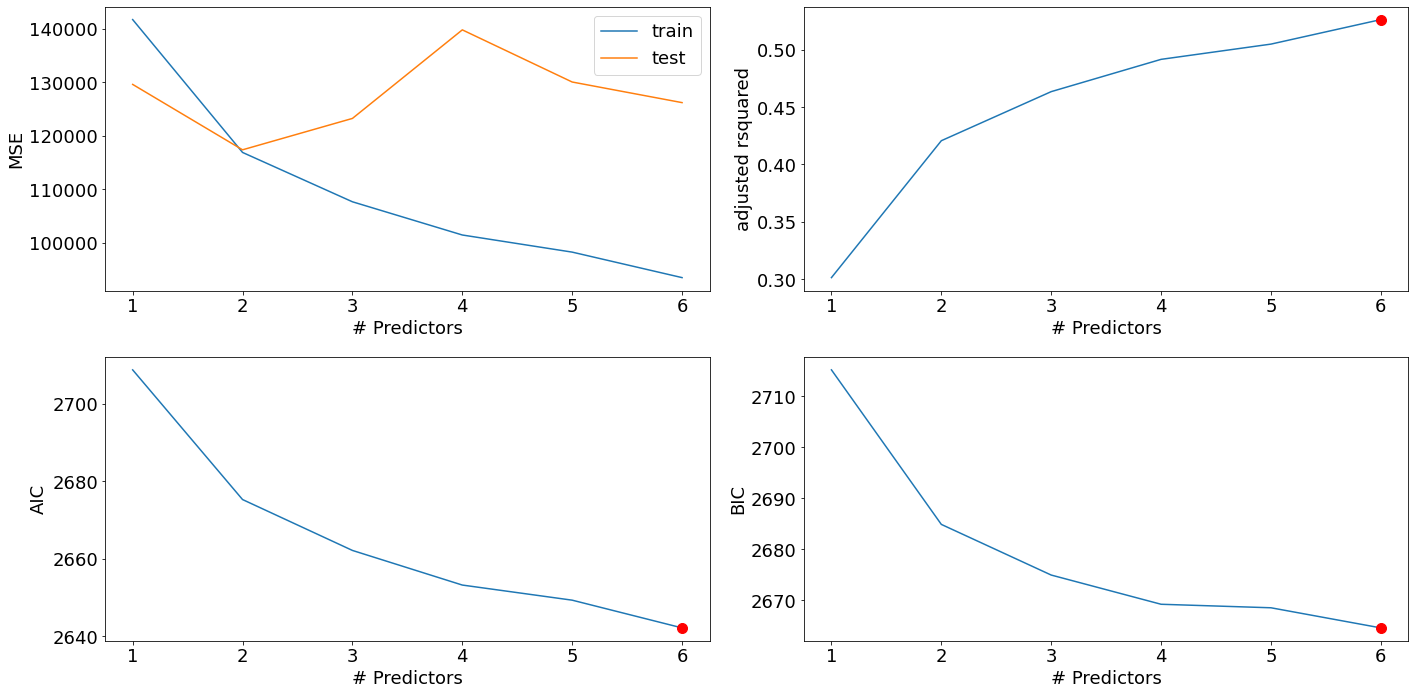

In [24]:
plotFeatureSelection(models_best)

We see that according to adjusted $R^2$ something, AIC, and BIC the 6-variable model is best. Again, no one measure is going to give us an entirely accurate picture... but they all agree that a model with 5 or fewer predictors is insufficient.

In summary, the Best Subset Selection approach resembles a brute force approach in the way that it simply tries all possible combinations. It becomes computationally heavy very quickly, even on small datasets (which is why we did not explore beyond k = 7 in the above example). 

## Option 2: Forward Selection

A more elegant approach is Forward Selection (FWS). With a slight modification, The Best Subset Selection code can be used for Forward Selection:

In [25]:
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns[1:-1] if p not in predictors]
    #print(remaining_predictors)
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
        #print(predictors+[p])
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (round(toc-tic,3)), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [26]:
models_fwd = pd.DataFrame(columns=["model", "RSS", "Train MSE", "Test MSE"])



tic = time.time()
predictors = ['const']
#predictors.append(X.)

for i in range(1,len(X.columns[1:-1])+1):    
    models_fwd.loc[i] = forward(predictors)
    predictors = models_fwd.loc[i]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  18 models on 2 predictors in 0.037 seconds.
Processed  17 models on 3 predictors in 0.03 seconds.
Processed  16 models on 4 predictors in 0.028 seconds.
Processed  15 models on 5 predictors in 0.026 seconds.
Processed  14 models on 6 predictors in 0.025 seconds.
Processed  13 models on 7 predictors in 0.025 seconds.
Processed  12 models on 8 predictors in 0.024 seconds.
Processed  11 models on 9 predictors in 0.022 seconds.
Processed  10 models on 10 predictors in 0.02 seconds.
Processed  9 models on 11 predictors in 0.02 seconds.
Processed  8 models on 12 predictors in 0.017 seconds.
Processed  7 models on 13 predictors in 0.014 seconds.
Processed  6 models on 14 predictors in 0.012 seconds.
Processed  5 models on 15 predictors in 0.018 seconds.
Processed  4 models on 16 predictors in 0.009 seconds.
Processed  3 models on 17 predictors in 0.007 seconds.
Processed  2 models on 18 predictors in 0.006 seconds.
Processed  1 models on 19 predictors in 0.003 seconds.
Total elapse

Forward-stepwise selection is a greedy algorithm, producing a nested sequence of models.

The forward selection approach runs sooooo much faster, even when evaluating models with large k values!

<img src="Images/vegeta.jpg" alt="Drawing" style="width: 350px;"/>

As in the Best Subset Selection, Forward Selection suggests that the best 2-variable model includes `Hits` and `CRBI` (not shown here). Additionally, we compare the best 6-variable model for each approach:

In [27]:
print(models_best.loc[6, "model"].summary())
print()
print(models_fwd.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     34.88
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.23e-27
Time:                        19:09:38   Log-Likelihood:                -1314.1
No. Observations:                 184   AIC:                             2642.
Df Residuals:                     177   BIC:                             2665.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Walks          3.8392      1.161      3.308      0.0

Both methods suggest different variables. Moreover, Forward Selection found the subset **significantly** faster!

Plotting MSE, adjusted $R^2$, AIC, and BIC for all of the models at once will help us decide which model to select:

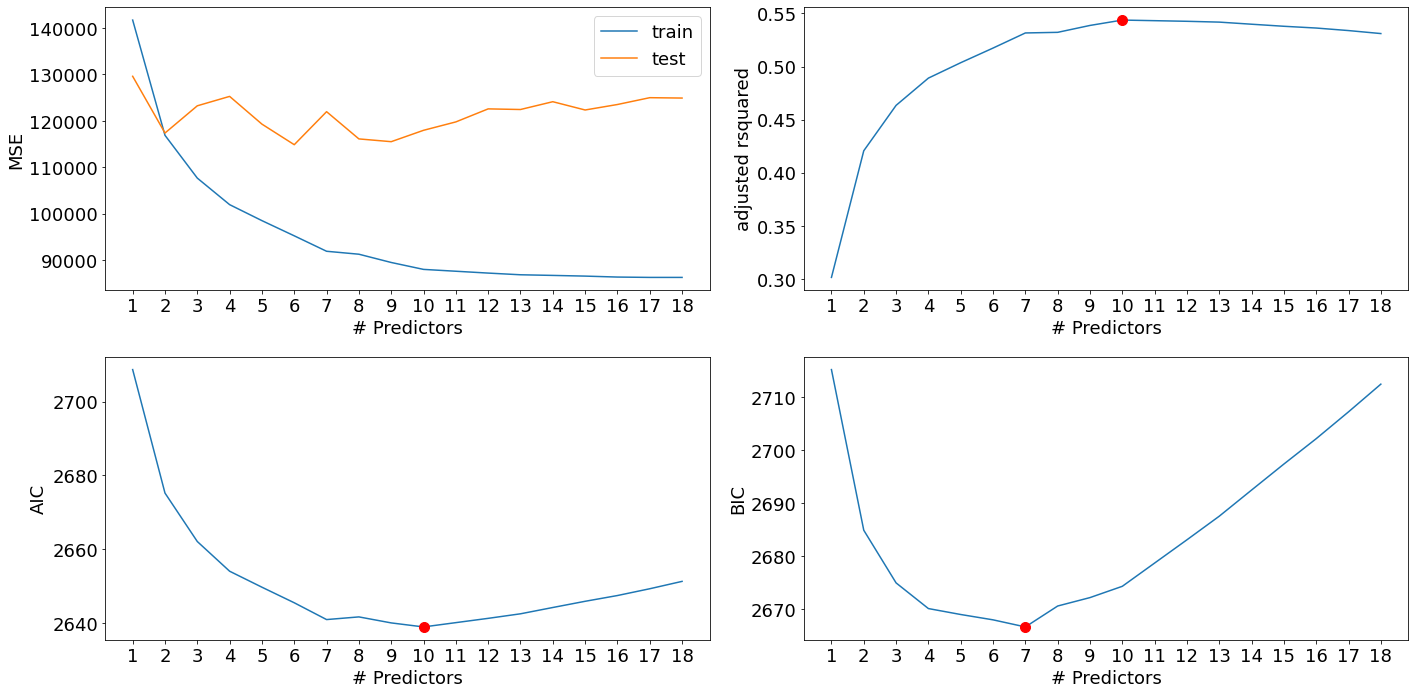

In [28]:
plotFeatureSelection(models_fwd)

Beware: once a variable is including in the model it will stay there!

## Option 3: Backwards Selection

We recycle the Forward Selection code, but loop through the predictors in reverse to perform Backwards Selection:

In [29]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-2):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['RSS'].idxmin()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (round(toc-tic,3)), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [30]:
models_bwd = pd.DataFrame(columns=["model", "RSS", "Train MSE", "Test MSE"])#, 
                          #index = range(1,len(X.columns)))

tic = time.time()
predictors = X.columns[1:-1]

while(len(predictors) > 1):  
    models_bwd.loc[len(predictors)-1] = backward(predictors)
    predictors = models_bwd.loc[len(predictors)-1]["model"].model.exog_names

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed  153 models on 17 predictors in 0.319 seconds.
Processed  136 models on 16 predictors in 0.273 seconds.
Processed  120 models on 15 predictors in 0.235 seconds.
Processed  105 models on 14 predictors in 0.202 seconds.
Processed  91 models on 13 predictors in 0.173 seconds.
Processed  78 models on 12 predictors in 0.148 seconds.
Processed  66 models on 11 predictors in 0.123 seconds.
Processed  55 models on 10 predictors in 0.101 seconds.
Processed  45 models on 9 predictors in 0.083 seconds.
Processed  36 models on 8 predictors in 0.064 seconds.
Processed  28 models on 7 predictors in 0.049 seconds.
Processed  21 models on 6 predictors in 0.038 seconds.
Processed  15 models on 5 predictors in 0.031 seconds.
Processed  10 models on 4 predictors in 0.018 seconds.
Processed  6 models on 3 predictors in 0.011 seconds.
Processed  3 models on 2 predictors in 0.005 seconds.
Processed  1 models on 1 predictors in 0.002 seconds.
Total elapsed time: 1.9213366508483887 seconds.


In [31]:
print(models_bwd.loc[6, "model"].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.517
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     38.14
Date:                Wed, 02 Mar 2022   Prob (F-statistic):           1.74e-26
Time:                        19:09:41   Log-Likelihood:                -1318.9
No. Observations:                 184   AIC:                             2650.
Df Residuals:                     178   BIC:                             2669.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Hits           1.9458      0.604      3.223      0.0

We plot the best 6-variable models for Best Subset, Forwards, and Backwards Selection:

In [32]:
for model, name in zip([models_best, models_fwd, models_bwd], ['Best Subset', 'Forward Selection', 'Backward Selection']):
    print("\n------------")
    print(name)
    print("------------")
    print(model.loc[6, "model"].params.sort_index())


------------
Best Subset
------------
CAtBat         -0.564019
CHits           2.055325
CHmRun          2.101613
Division_W   -138.755836
PutOuts         0.305372
Walks           3.839172
const         216.558213
dtype: float64

------------
Forward Selection
------------
AtBat          -2.290507
CRBI            0.585546
Division_W   -120.781447
Hits            8.628968
PutOuts         0.353988
Walks           3.425734
const         142.512798
dtype: float64

------------
Backward Selection
------------
CAtBat     -0.465784
CHits       1.694425
CHmRun      2.310292
Hits        1.945801
PutOuts     0.322634
const      78.962842
dtype: float64


Plotting MSE, adjusted $R^2$, AIC, and BIC for all of the models at once will help us decide which model to select:

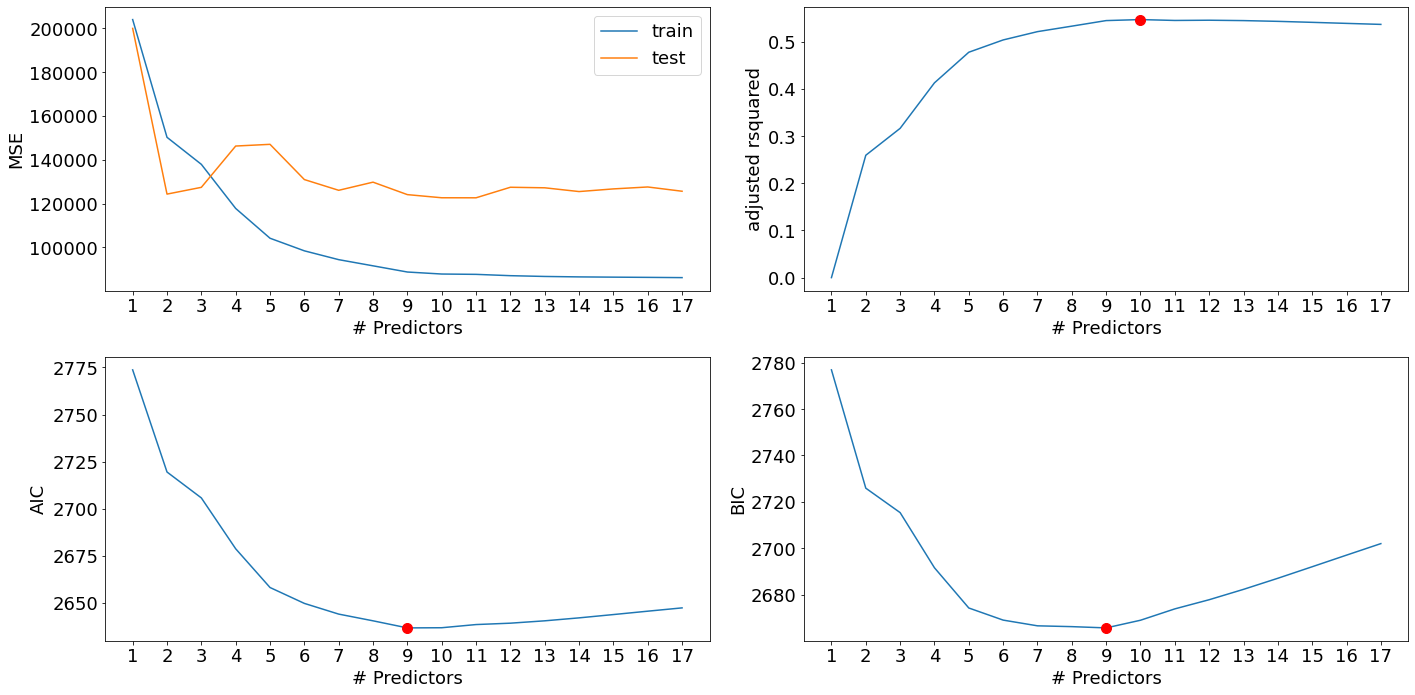

In [33]:
plotFeatureSelection(models_bwd)

<img src="Images/variancebias_edit_3.png" alt="Drawing" style="width: 700px;"/>

## Option 4: Ridge Regression

Ridge estimates are found by minimizing (from slides):

<img src="Images/ridge.png" alt="Drawing" style="width: 500px;"/>

- As with least squares, ridge regression seeks coefficient estimates that fit the data well, by making the RSS small.
- **The second term is a penalty that shrinks the coefficients towards zero**
- Though not immediately obvious, shrinking can help to reduce variance
- The estimates are very sensitive to the “tuning parameter” lambda -> needs to be found separately using cross validation!
- The tuning parameter controls the relative impact of RSS and penalty on the regression coefficient estimates.

We will use a `sklearn` package in order to perform ridge regression. Specifically, we will be using `Ridge()` to fit ridge regression models and its cross-validated counterpart `RidgeCV()`.


The `Ridge()` function has an alpha argument **($\lambda$, but with a different name!)** that is used to tune the model. We'll generate an array of alpha values ($\lambda$!!!) ranging from very big to very small, essentially covering the full range of scenarios from the null model containing only the intercept, to the least squares fit:

In [34]:
np.set_printoptions(suppress=True, precision=2)

In [35]:
alphas = 10**np.linspace(10,-2,100)*0.5
alphas

array([5.00e+09, 3.78e+09, 2.86e+09, 2.16e+09, 1.64e+09, 1.24e+09,
       9.37e+08, 7.09e+08, 5.36e+08, 4.06e+08, 3.07e+08, 2.32e+08,
       1.76e+08, 1.33e+08, 1.00e+08, 7.60e+07, 5.75e+07, 4.35e+07,
       3.29e+07, 2.49e+07, 1.88e+07, 1.42e+07, 1.08e+07, 8.15e+06,
       6.16e+06, 4.66e+06, 3.53e+06, 2.67e+06, 2.02e+06, 1.53e+06,
       1.16e+06, 8.74e+05, 6.61e+05, 5.00e+05, 3.78e+05, 2.86e+05,
       2.16e+05, 1.64e+05, 1.24e+05, 9.37e+04, 7.09e+04, 5.36e+04,
       4.06e+04, 3.07e+04, 2.32e+04, 1.76e+04, 1.33e+04, 1.00e+04,
       7.60e+03, 5.75e+03, 4.35e+03, 3.29e+03, 2.49e+03, 1.88e+03,
       1.42e+03, 1.08e+03, 8.15e+02, 6.16e+02, 4.66e+02, 3.53e+02,
       2.67e+02, 2.02e+02, 1.53e+02, 1.16e+02, 8.74e+01, 6.61e+01,
       5.00e+01, 3.78e+01, 2.86e+01, 2.16e+01, 1.64e+01, 1.24e+01,
       9.37e+00, 7.09e+00, 5.36e+00, 4.06e+00, 3.07e+00, 2.32e+00,
       1.76e+00, 1.33e+00, 1.00e+00, 7.60e-01, 5.75e-01, 4.35e-01,
       3.29e-01, 2.49e-01, 1.88e-01, 1.42e-01, 1.08e-01, 8.15e

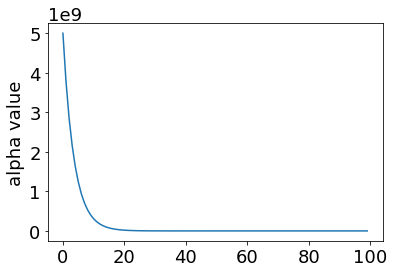

In [36]:
plt.plot(alphas)
plt.ylabel('alpha value');

Associated with each alpha value is a vector of ridge regression coefficients, which we'll store in a matrix `coefs`. In this case, it is a $19 \times 100$ matrix, with 19 rows (one for each predictor) and 100 columns (one for each value of alpha). Remember that we'll want to standardize the variables so that they are on the same scale. To do this, we can use the `normalize = True` parameter:

In [37]:
ridge = Ridge(normalize = True)
coefs = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)
    
np.shape(coefs)

(100, 20)

We expect the coefficient estimates to be much smaller, in terms of $l_2$ norm, when a large value of alpha is used, as compared to when a small value of alpha is used. Let's plot and find out:

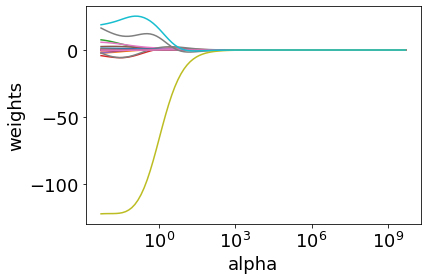

In [38]:
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

Next we fit a ridge regression model on the training set, and evaluate its MSE on the test set, using $\lambda = 4$ (the lambda value is **chosen randomly** for illustrative purposes. We'll cover how to pick an optimal value in a second):

In [39]:
ridge2 = Ridge(alpha = 4, normalize = True).fit(X_train, y_train) # Fit a ridge regression on the training data
pred2 = ridge2.predict(X_test) # Use this model to predict the test data
print(pd.Series(ridge2.coef_, index = X.columns)) # Print coefficients

print('\nTraining MSE: ' + str(round(mean_squared_error(y_train, ridge2.predict(X_train)), 0)))
print('\nTest MSE:     ' + str(round(mean_squared_error(y_test, ridge2.predict(X_test)), 0)))

const           0.000000
AtBat           0.107993
Hits            0.473495
HmRun           1.399789
Runs            0.675409
RBI             0.822569
Walks           0.901355
Years           2.365136
CAtBat          0.007420
CHits           0.029945
CHmRun          0.261695
CRuns           0.057900
CRBI            0.067693
CWalks          0.053269
PutOuts         0.086797
Assists        -0.013971
Errors          0.153121
League_N        1.057862
Division_W    -27.855268
NewLeague_N     3.819842
dtype: float64

Training MSE: 125374.0

Test MSE:     129245.0


<img src="Images/variancebias_edit_4.png" alt="Drawing" style="width: 700px;"/>

The test MSE when alpha = 4 is 129,245. Now let's see what happens if we use a huge value of alpha, say $10^{10}$:

In [40]:
ridge3 = Ridge(alpha = 10**10, normalize = True)
ridge3.fit(X_train, y_train)             # Fit a ridge regression on the training data
pred3 = ridge3.predict(X_test)           # Use this model to predict the test data
print(pd.Series(ridge3.coef_, index = X.columns)) # Print coefficients
print('\nTraining MSE: ' + str(round(mean_squared_error(y_train, ridge3.predict(X_train)), 0)))
print('\nTest MSE:     ' + str(round(mean_squared_error(y_test, ridge3.predict(X_test)), 0)))

const          0.000000e+00
AtBat          1.289497e-10
Hits           4.608072e-10
HmRun          1.905632e-09
Runs           7.623916e-10
RBI            8.735153e-10
Walks          9.114154e-10
Years          3.352330e-09
CAtBat         9.159260e-12
CHits          3.391950e-11
CHmRun         2.787049e-10
CRuns          6.759012e-11
CRBI           7.298246e-11
CWalks         7.250350e-11
PutOuts        6.313977e-11
Assists       -4.436847e-12
Errors         9.694369e-11
League_N      -5.970420e-09
Division_W    -1.623587e-08
NewLeague_N   -4.034523e-09
dtype: float64

Training MSE: 203970.0

Test MSE:     199951.0


This big penalty shrinks the coefficients to a very large degree, essentially reducing to a model containing just the intercept. This **over-shrinking makes the model more biased**, resulting in a higher MSE.

<img src="Images/variancebias_edit_5.png" alt="Drawing" style="width: 700px;"/>

Okay, so fitting a ridge regression model with alpha = 4 leads to a much lower test MSE than fitting a model with just an intercept. We now check whether there is any benefit to performing ridge regression with alpha = 4 instead of just performing least squares regression. Recall that least squares is simply ridge regression with alpha = 0.

In [41]:
ridge4 = Ridge(alpha = 0, normalize = True).fit(X_train, y_train)             # Fit a ridge regression on the training data
pred = ridge4.predict(X_test)            # Use this model to predict the test data
print(pd.Series(ridge4.coef_, index = X.columns)) # Print coefficients
print('\nTraining MSE: ' + str(round(mean_squared_error(y_train, ridge4.predict(X_train)), 0)))
print('\nTest MSE:     ' + str(round(mean_squared_error(y_test, ridge4.predict(X_test)), 0)))

const            0.000000
AtBat           -2.222964
Hits             7.606262
HmRun           -2.920254
Runs            -2.260796
RBI              2.188527
Walks            5.664732
Years            6.983902
CAtBat          -0.333004
CHits            1.076608
CHmRun           2.023639
CRuns            0.422991
CRBI             0.143343
CWalks          -0.478938
PutOuts          0.310889
Assists          0.133993
Errors          -0.143540
League_N        29.003932
Division_W    -124.844775
NewLeague_N     13.518478
dtype: float64

Training MSE: 86228.0

Test MSE:     125103.0


It looks like we are indeed improving over regular least-squares!

Instead of arbitrarily choosing alpha $ = 4$, it would be better to use cross-validation to choose the tuning parameter alpha. We can do this using the cross-validated ridge regression function, `RidgeCV()`. By default, the function performs generalized cross-validation (an efficient form of LOOCV), though this can be changed using the argument `cv`.

In [42]:
ridgecv = RidgeCV(alphas=alphas, scoring = 'neg_mean_squared_error', normalize = True)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

0.008737642000038414

Therefore, we see that the value of alpha that results in the smallest cross-validation
error is 0.57. What is the test MSE associated with this value of
alpha?

In [43]:
ridge5 = Ridge(alpha = ridgecv.alpha_, normalize = True).fit(X_train, y_train)
mean_squared_error(y_test, ridge5.predict(X_test))
print('\nTraining MSE: ' + str(round(mean_squared_error(y_train, ridge5.predict(X_train)), 0)))
print('\nTest MSE:    ' + str(round(mean_squared_error(y_test, ridge5.predict(X_test)), 0)))


Training MSE: 88176.0

Test MSE:    119042.0


Unlike subset selection, which will generally select models that involve just a subset of the variables, 
<font color='red'>**ridge regression will include all p predictors in the final model!** </font>

## Option 5: LASSO

Similar to ridge regression, but the key difference in behavior follows from penalty:

<img src="Images/lasso.png" alt="Drawing" style="width: 500px;"/>

We saw that ridge regression with a wise choice of alpha can outperform least
squares as well as the null model on the Hitters data set. We now ask
whether the lasso can yield either a more accurate or a more interpretable
model than ridge regression. In order to fit a lasso model, we'll
use the `Lasso()` function; however, this time we'll need to include the argument `max_iter = 10000`.
Other than that change, we proceed just as we did in fitting a ridge model:

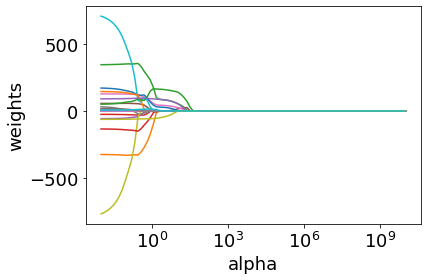

In [44]:
lasso = Lasso(max_iter = 10000, normalize = True)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(scale(X_train.astype(float)), y_train)
    coefs.append(lasso.coef_)
    
ax = plt.gca()
ax.plot(alphas*2, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

Notice that in the coefficient plot that depending on the choice of tuning
parameter, some of the coefficients are exactly equal to zero. We now
perform 10-fold cross-validation to choose the best alpha, refit the model, and compute the associated test error:

In [45]:
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000, normalize = True)
lassocv.fit(X_train, y_train)

lasso.set_params(alpha=lassocv.alpha_)
lasso.fit(X_train, y_train)
print('\nTraining MSE: ' + str(round(mean_squared_error(y_train, lasso.predict(X_train)), 0)))
print('\nTest MSE:    ' + str(round(mean_squared_error(y_test, lasso.predict(X_test)), 0)))


Training MSE: 86804.0

Test MSE:    121178.0


This is substantially lower than the test set MSE of the null model and of
least squares, and only a little worse than the test MSE of ridge regression with alpha
chosen by cross-validation.

**However, the lasso has a substantial advantage over ridge regression in that the resulting coefficient estimates are sparse.** Here we see that 13 of
the 19 coefficient estimates are exactly zero:

In [46]:
# Some of the coefficients are now reduced to exactly zero.
pd.Series(lasso.coef_, index=X.columns)

const            0.000000
AtBat           -2.267186
Hits             7.758589
HmRun           -3.287416
Runs            -2.002968
RBI              2.204797
Walks            5.577079
Years            0.000000
CAtBat          -0.183021
CHits            0.628739
CHmRun           1.717085
CRuns            0.383991
CRBI             0.200774
CWalks          -0.510605
PutOuts          0.319788
Assists          0.083395
Errors           0.000000
League_N        19.725022
Division_W    -122.093616
NewLeague_N     16.710288
dtype: float64

## LASSO vs. Ridge

<img src="Images/ridgevslasso.png" alt="Drawing" style="width: 800px;"/>

## Final thoughts

- dont use the forward and backwards selection code that was used in this tutorial! It is simple but inefficient!
- Forward selection using mlxtend -> Sequential Feature Selector: https://www.kdnuggets.com/2018/06/step-forward-feature-selection-python.html